# Example Notebook for Tektronix Keithley 2450 source meter

In this example we will setup a number of [four-wire measurements](https://en.wikipedia.org/wiki/Four-terminal_sensing) with the 2540 source meter. We attach a variable resistor to the front terminals and determine if we can measure the correct resistance.

In [1]:
from qcodes import MatPlot, Measure
from qcodes.instrument_drivers.tektronix.Keithley_2450 import Keithley2450

In [2]:
keithley = Keithley2450("source", "GPIB0::18::INSTR")

Connected to: KEITHLEY INSTRUMENTS 2450 (serial:04397524, firmware:1.6.4c) in 0.04s


In [3]:
keithley.terminals("FRONT")

For the first measurement, we drive a current through the resistor and measure the voltage accross it. 

In [4]:
keithley.source.function("CURR")
keithley.sense.function("VOLT")
keithley.sense.four_wire_measurement(True)
keithley.output(True)

Sweep the current from 0 to 1uA in 10 steps

DataSet:
   location = 'data/2019-04-11/#039_{name}_16-24-20'
   <Type>   | <array_id>   | <array.name> | <array.shape>
   Measured | source_sweep | sweep        | (10,)
acquired at 2019-04-11 16:24:21


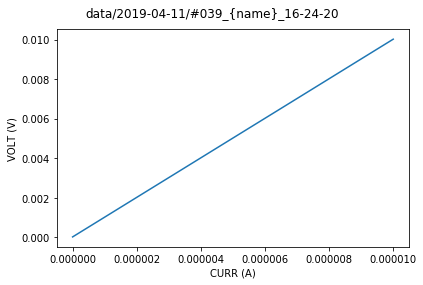

In [5]:
keithley.sweep.setup(0, 10E-6, 10)
data = Measure(keithley.sweep).run()
MatPlot(data.arrays['source_sweep'])

We see from the slope that we have a 1kOhm resistance (which is correct). Next, lets increase the resistance to 3kOhm

DataSet:
   location = 'data/2019-04-11/#040_{name}_16-24-50'
   <Type>   | <array_id>   | <array.name> | <array.shape>
   Measured | source_sweep | sweep        | (10,)
acquired at 2019-04-11 16:24:51


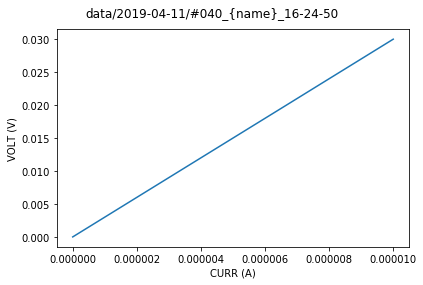

In [6]:
keithley.sweep.setup(0, 10E-6, 10)
data = Measure(keithley.sweep).run()
MatPlot(data.arrays['source_sweep'])

In [7]:
keithley.measure()

0.01001324

In [8]:
keithley.measure.unit

'V'

We indeed see that the resistance has increased to 3kOhm. Now we will turn the resistance back to 1kOhm and sweep the voltage and measure the current 

In [12]:
keithley.sense.function("CURR")
keithley.sense.range(1E-5)
keithley.sense.four_wire_measurement(True)
keithley.source.function("VOLT")
keithley.source.range(0.2)
keithley.source.limit(0.001)

DataSet:
   location = 'data/2019-04-11/#041_{name}_16-29-32'
   <Type>   | <array_id>   | <array.name> | <array.shape>
   Measured | source_sweep | sweep        | (10,)
acquired at 2019-04-11 16:29:32


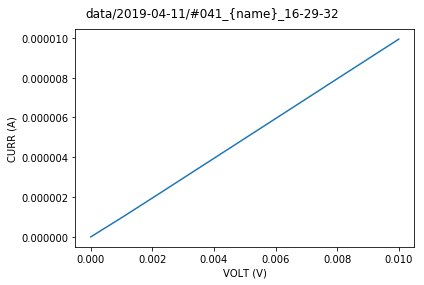

In [13]:
keithley.sweep.setup(0, 0.01, 10)
data = Measure(keithley.sweep).run()
MatPlot(data.arrays['source_sweep'])

In [14]:
keithley.sense.function("RES")
keithley.sense.range(10E3)
keithley.sense.four_wire_measurement(True)
keithley.source.function("VOLT")
keithley.source.range(0.2)
keithley.source.limit(0.001)

DataSet:
   location = 'data/2019-04-11/#042_{name}_16-31-24'
   <Type>   | <array_id>   | <array.name> | <array.shape>
   Measured | source_sweep | sweep        | (10,)
acquired at 2019-04-11 16:31:24


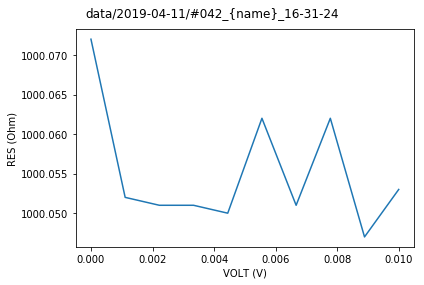

In [15]:
keithley.sweep.setup(0, 0.01, 10)
data = Measure(keithley.sweep).run()
MatPlot(data.arrays['source_sweep'])